# Implementation of HOG extractor

- In this notebook, you will work on implementing HOG extractor. There are several **blanks** you need to fill in.
- Extraction of HOG feature from an image proceeds as follows:
    1. computing the gradient image in x and y
    2. computing the magnitude and orientation from the gradients
    3. computing gradient histograms
    4. normalizing across blocks and flattening into a feature vector
    5. putting them together

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, exposure
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import draw
from scipy import pi
from scipy.ndimage import uniform_filter

from hog import hog

## 1. Computing the gradient image in x and y

- In this section, we will implement the function which computes the gradients from input image.
- There are two types of the gradients on the two axis; x-axis and y-axis.
    - $I_x$ is the gradient on x-axis, which is calculated as follows:
    $$
    I_x(x,y) = \frac{I(x+1, y) - I(x-1,y)}{2}
    $$
    - $I_y$ is the gradient on y-axis, which is calculated as follows:
    $$
    I_y(x,y) = \frac{I(x, y+1) - I(x,y-1)}{2}
    $$
    - Use $diff_x, diff_y$ to calculate above.

In [ ]:
def compute_gradients(image):
    """
    Compute the gradient of the image vertically and horizontally.
    
    Parameters
    ----------
    image : (X, Y) Input image array. 
    
    Returns
    -------
    I_x: the gradient on x-axis.
    I_y: the gradient on y-axis.
    """
    
    image = np.atleast_2d(image)
        
    # initialize the parameters.
    I_x = np.zeros(image.shape)
    I_y = np.zeros(image.shape)
    
    ########## START CODE HERE ##########
    diff_x = np.diff(image, n=1, axis=1)
    diff_y = np.diff(image, n=1, axis=0)
    I_x[:, 1:-1] = (diff_x[:, :-1] + diff_x[:, 1:]) / 2 # TODO
    I_y[1:-1, :] = (diff_y[:-1] + diff_y[1:]) / 2 # TODO
    ########## END CODE HERE ##########
    
    return I_x, I_y

In [ ]:
# test 1
image = np.arange(16).reshape(4, 4)
I_x, I_y = compute_gradients(image)
assert (I_x == np.array([[0, 1, 1, 0]]* 4)).all()
assert (I_y == np.array([[0, 0, 0, 0], [4, 4, 4, 4], [4, 4, 4, 4], [0, 0, 0, 0]])).all()

## 2. computing the magnitude and orientation from the gradients

- Now we have the gradients $I_x, I_y$. Let's calculate magnitude $m$ and orientation $\theta$ from the gradients.
- Note that magnitude $m$ and orientation $\theta$ are calculated as follows:
$$
m(x,y) = \sqrt{{I_x(x,y)}^2 + {I_y(x,y)}^2}\\
\theta(x,y) = \tan^{-1}\frac{I_y(x,y)}{I_x(x,y)} \times \frac{180^\circ}{\pi}\ \ \  (0^\circ \le \theta < 180^\circ)
$$
- $\theta$ is expressed in **degrees**.
- Keep in mind that $\theta$ does not exceed $180^\circ$.

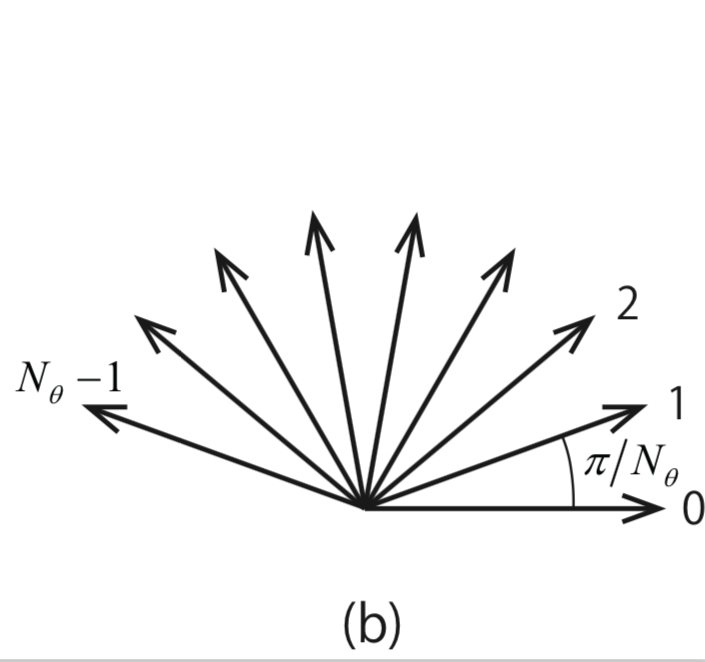

In [ ]:
def compute_magnitude_and_orientation(I_x, I_y):
    """
    Compute the magnitude and orientation from the gradients I_x, I_y.
    
    Parameters
    ----------
    I_x: the gradient on x-axis.
    I_y: the gradient on y-axis.
    
    Returns
    -------
    m: magnitude of the gradient.
    orientation: orientation of the gradient.
    """
    
    magnitude = np.sqrt(I_x**2 + I_y**2) # TODO
    orientation = np.arctan2(I_y, I_x) * (180 / pi) % 180 # TODO

    return magnitude, orientation

In [ ]:
# test 1
image = np.arange(16).reshape(4, 4)
I_x, I_y = compute_gradients(image)
magnitude, orientation = compute_magnitude_and_orientation(I_x, I_y)
expected_magnitude = np.load('./arrays_for_testing/magnitude_1.npy')
expected_orientation = np.load('./arrays_for_testing/orientation_1.npy')
assert np.sum((magnitude - expected_magnitude)**2) < 1e-3
assert np.sum((orientation - expected_orientation)**2) < 1e-3

# test 2
## thetaが180を超えるやつ

## 3. Computing gradient histograms

- これは載せるか迷う

In [ ]:
def compute_gradient_histograms(magnitude, orientation, N_theta=9, N_p=5, N_c=3):
    """
    Compute the gradient histograms of the image from the magnitude and orientation.
    
    Parameters
    ----------
    magnitude: magnitude of the gradient.
    orientation: orientation of the gradient.
    
    Returns
    -------
    orientation_histogram: histogram in each pixel.
    """

    sx, sy = magnitude.shape

    N_x = int(np.floor(sx // N_p))  # number of cells in x
    N_y = int(np.floor(sy // N_p))  # number of cells in y

    # compute N_theta integral images
    orientation_histogram = np.zeros((N_x, N_y, N_theta))
    subsample = np.index_exp[N_p // 2:N_p * N_x:N_p,
                             N_p // 2:N_p * N_y:N_p]
    for i in range(N_theta):
        # create new integral image for this orientation
        # isolate N_theta in this range

        temp_ori = np.where(orientation < 180.0 / N_theta * (i + 1),
                            orientation, -1)
        temp_ori = np.where(orientation >= 180.0 / N_theta * i,
                            temp_ori, -1)
        # select magnitudes for those N_theta
        cond2 = temp_ori > -1
        temp_mag = np.where(cond2, magnitude, 0)

        temp_filt = uniform_filter(temp_mag, size=(N_p, N_p))
        orientation_histogram[:, :, i] = temp_filt[subsample]
    return orientation_histogram

In [ ]:
# test

## 4. Normalizing across blocks and Flattening into a feature vector

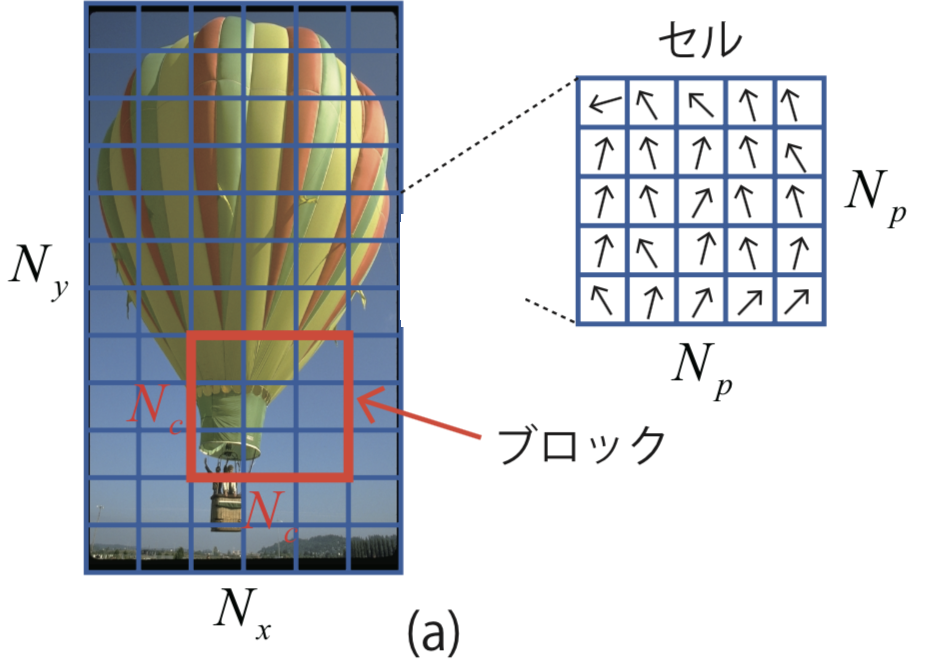

In [ ]:
def normalize_across_block_and_flatten(orientation_histogram, N_theta, N_c, N_x, N_y, eps=1e-5):
    """
    Normalize histogram across blocks and flattening it into a
    """
    n_blocksx = (N_x - N_c) + 1
    n_blocksy = (N_y - N_c) + 1
    normalised_blocks = np.zeros((n_blocksx, n_blocksy,
                                  N_c, N_c, N_theta))

    for x in range(n_blocksx):
        for y in range(n_blocksy):
            block = orientation_histogram[x:x + N_c, y:y + N_c, :]
            normalised_blocks[x, y, :] = block / np.sqrt(block.sum()**2 + eps) # TODO
    
    return normalised_blocks.ravel()

## 5. Putting them together

In [ ]:
def calculate_hog(image, N_theta=9, N_p=5, N_c=3, visualize=True):    
    # check if the input image is gray level
    if image.ndim > 2:
        raise ValueError("Currently only supports grey-level images")\
    
    if image.dtype.kind == 'u':
        # convert uint image to float
        # to avoid problems with subtracting unsigned numbers in np.diff()
        image = image.astype('float')
        
    # change the alingment of input image from (Y, X) to (X, Y)
    image = np.transpose(image, (1, 0))
    
    # 1. computing the gradient image in x and y
    I_x, I_y = compute_gradients(image)
    
    # 2. computing the magnitude and orientation from the gradients
    magnitude, orientation = compute_magnitude_and_orientation(I_x, I_y)
    
    # 3. Computing gradient histograms
    orientation_histogram = compute_gradient_histograms(magnitude, orientation,\
                                                       N_theta, N_p, N_c)
    print(np.transpose(orientation_histogram, (1, 0, 2)))
    # 4. Normalizing across blocks and Flattening into a feature vector
    N_x = int(np.floor(image.shape[0] // N_p))  # number of cells in x
    N_y = int(np.floor(image.shape[1] // N_p))  # number of cells in y
    hog_feature = normalize_across_block_and_flatten(orientation_histogram, N_theta, N_c, N_x, N_y)
    assert hog_feature.shape[0] == (N_c**2 * N_theta) * (N_x - N_c + 1) * (N_y - N_c + 1)
    
    if visualize == True:
        hog_image = obtain_hog_image(orientation_histogram, image.transpose(), N_theta, N_p, N_c)
        return hog_feature, hog_image
    else:
        return hog_feature

In [ ]:
def obtain_hog_image(orientation_histogram, image, N_theta, N_p=5, N_c=3):
    sy, sx = image.shape[:2]
    hog_image = None

    N_x = int(np.floor(sx // N_p))  # number of cells in x
    N_y = int(np.floor(sy // N_p))  # number of cells in y
    radius = N_p // 2 - 1
    hog_image = np.zeros((sy, sx), dtype=float)
    for x in range(N_x):
        for y in range(N_y):
            for o in range(N_theta):
                centre = tuple([y * N_p + N_p // 2, x * N_p + N_p // 2])
                dx = radius * np.cos(float(o) / N_theta * np.pi)
                dy = radius * np.sin(float(o) / N_theta * np.pi)
                rr, cc = draw.line(int(centre[0] - dx),
                                    int(centre[1] - dy),
                                    int(centre[0] + dx),
                                    int(centre[1] + dy))
                hog_image[rr, cc] += orientation_histogram[x, y, o]
    return hog_image

In [ ]:
# Demonstartion
image = imread("61A19zu3HlL._AC_SS500_SR1000,500_.jpg")
print(image.shape)
gray_image = rgb2gray(image)
#plt.imshow(gray_image, cmap=plt.cm.gray)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image)
hog_feature, hog_image = calculate_hog(gray_image)
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap=plt.cm.gray)

In [ ]:
# Demonstartion
image = imread("61A19zu3HlL._AC_SS500_SR1000,500_.jpg")
#gray_image = rgb2gray(image)
#plt.imshow(gray_image, cmap=plt.cm.gray)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image)
hog_feature, hog_image = hog(gray_image, visualise=True)
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap=plt.cm.gray)